# Required Libraries

In [1]:
import numpy as np                            
import astropy.units as u                     
import matplotlib.pyplot as plt               
import sunpy.map                               
from astropy.coordinates import SkyCoord       
from skimage.measure import label, regionprops 
from sunpy.net import Fido                     
from sunpy.net import attrs as a              
from aiapy.calibrate import register          
import pandas as pd                            
from matplotlib.colors import Normalize   
from matplotlib.lines import Line2D
plt.ion()                                     

# Data Acquisition

| Component                        | Purpose                                  |
| -------------------------------- | ---------------------------------------- |
| `a.Time(...)`                    | Specifies the time range of observation  |
| `a.Instrument.aia`               | Selects the AIA instrument (on SDO)      |
| `a.Wavelength(193 * u.angstrom)` | Requests AIA images in the 193 Å channel |
| `a.Physobs.intensity`            | Requests intensity (EUV emission) data   |


# Get AIA data 

In [2]:
AIA_DATA=Fido.search(a.Time('2015/07/07 11:44:10','2015/07/07 11:44:30'),a.Instrument.aia, a.Wavelength(193*u.angstrom),a.Physobs.intensity)

In [3]:
AIA_Data=Fido.fetch(AIA_DATA)

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

In [4]:
AIA_Data

['/Users/khagendrakatwal/sunpy/data/aia_lev1_193a_2015_07_07t11_44_17_84z_image_lev1.fits', '/Users/khagendrakatwal/sunpy/data/aia_lev1_193a_2015_07_07t11_44_29_84z_image_lev1.fits']

# Get HMI data

In [5]:
HMI_DATA=Fido.search(a.Time('2015/07/07 11:43:10','2015/07/07 11:43:59'),a.Instrument.hmi, a.Physobs.los_magnetic_field)
HMI_Data=Fido.fetch(HMI_DATA)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

In [6]:
aia193 = sunpy.map.Map(AIA_Data[0])
hmi6173 = sunpy.map.Map(HMI_Data[0])

# Coalign AIA with HMI

We reproject the AIA map to match the HMI grid to avoid interpolating HMI's LOS magnetic field, as interpolation may distort small-scale variations important for analysis. 

In [7]:
aia_reprojected = aia193.reproject_to(hmi6173.wcs)
aia_reprojected.nickname = 'AIA 193 Å (Reprojected)'

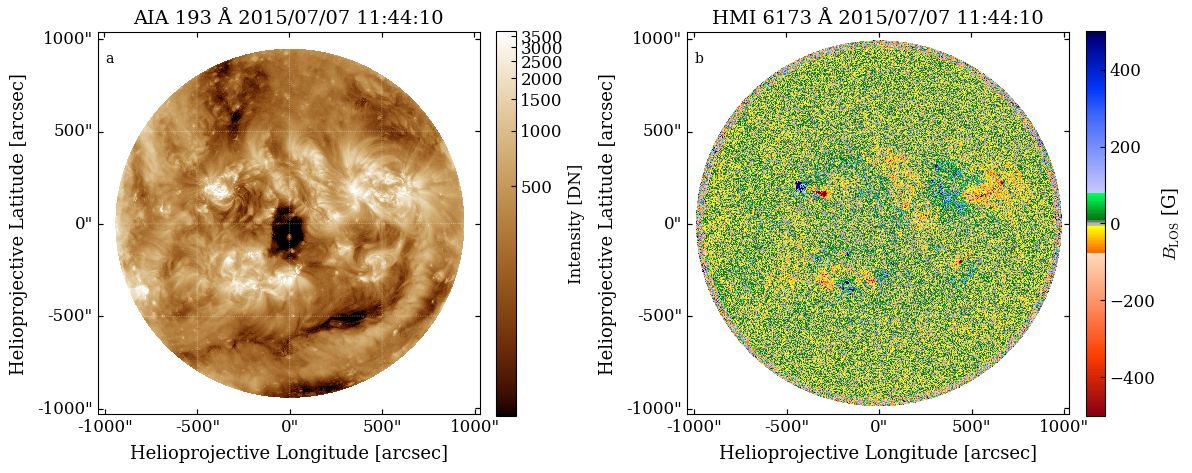

In [8]:
# ApJ-uniform global
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# Create the figure
fig = plt.figure(figsize=(12,6))

# ---------------- AIA 193 Å ----------------
ax1 = fig.add_subplot(121, projection=aia_reprojected.wcs)
im1 = aia_reprojected.plot(axes=ax1, clip_interval=(1, 99.9) * u.percent)

ax1.set_title("AIA 193 Å 2015/07/07 11:44:10", fontsize=14, fontfamily="serif")

cb1 = fig.colorbar(im1, ax=ax1, orientation='vertical', fraction=0.046, pad=0.04)
cb1.set_label("Intensity [DN]", fontsize=12, fontfamily="serif")
cb1.ax.tick_params(labelsize=12)

ax1.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)

# Force uniform font on axis labels (works on all versions)
ax1.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13, fontfamily="serif")
ax1.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13, fontfamily="serif")

ax1.tick_params(labelsize=12)
ax1.invert_xaxis()
ax1.invert_yaxis()
ax1.text(0.02, 0.95, "a", transform=ax1.transAxes,
         va="top", ha="left", fontfamily="serif")

# ---------------- HMI 6173 Å ----------------
ax2 = fig.add_subplot(122, projection=hmi6173.wcs)
im2 = hmi6173.plot(axes=ax2, cmap="hmimag", norm=Normalize(-500, 500))

ax2.set_title("HMI 6173 Å 2015/07/07 11:44:10", fontsize=14, fontfamily="serif")

cb2 = fig.colorbar(im2, ax=ax2, orientation='vertical', fraction=0.046, pad=0.04)
cb2.set_label(r"$B_{\mathrm{LOS}}$ [G]", fontsize=13, fontfamily="serif")
cb2.ax.tick_params(labelsize=12)

ax2.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)

# Force uniform font on axis labels (works on all versions)
ax2.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13, fontfamily="serif")
ax2.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13, fontfamily="serif")

ax2.tick_params(labelsize=12)
ax2.invert_xaxis()
ax2.invert_yaxis()
ax2.text(0.02, 0.95, "b", transform=ax2.transAxes,
         va="top", ha="left", fontfamily="serif")

plt.tight_layout(pad=1.0)
plt.show()

# Select Region of interest

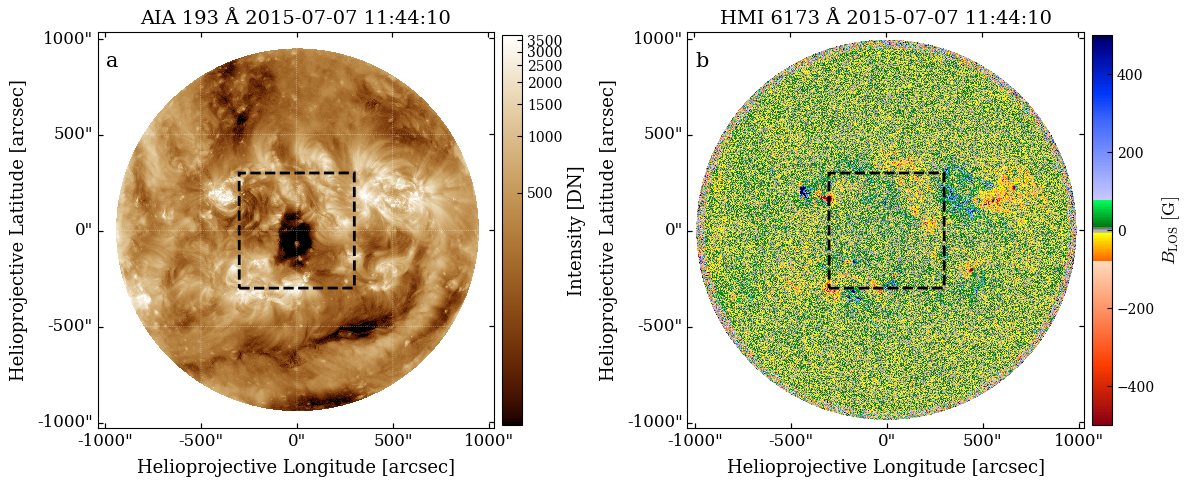

In [21]:
# -------------------------------------------------
# Global ApJ-safe style (ONE place, deterministic)
# -------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# -------------------------------------------------
# Define corners in the AIA coordinate frame
# -------------------------------------------------
aia_bottom_left = SkyCoord(-300 * u.arcsec, -300 * u.arcsec,
                           frame=aia_reprojected.coordinate_frame)
aia_top_right   = SkyCoord( 300 * u.arcsec,  300 * u.arcsec,
                           frame=aia_reprojected.coordinate_frame)

# -------------------------------------------------
# Create figure
# -------------------------------------------------
fig = plt.figure(figsize=(12, 6))

# ===================== AIA Plot =====================
ax1 = fig.add_subplot(121, projection=aia_reprojected.wcs)
im1 = aia_reprojected.plot(
    axes=ax1,
    clip_interval=(1, 99.9) * u.percent
)

aia_reprojected.draw_quadrangle(
    bottom_left=aia_bottom_left,
    top_right=aia_top_right,
    axes=ax1,
    edgecolor="black",
    linestyle="--",
    linewidth=2
)

ax1.set_title("AIA 193 Å 2015-07-07 11:44:10", fontsize=14)

ax1.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)

# Enforce uniform label rendering (Astropy-safe)
ax1.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)

ax1.tick_params(labelsize=12)
ax1.invert_xaxis()
ax1.invert_yaxis()

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label("Intensity [DN]", fontsize=13)
cbar1.ax.tick_params(labelsize=10)

ax1.text(
    0.02, 0.95, "a",
    transform=ax1.transAxes,
    va="top", ha="left",
    fontsize=15
)

# ===================== HMI Plot =====================
ax2 = fig.add_subplot(122, projection=hmi6173.wcs)
im2 = hmi6173.plot(
    axes=ax2,
    cmap="hmimag",
    norm=Normalize(-500, 500)
)

hmi6173.draw_quadrangle(
    bottom_left=aia_bottom_left,
    top_right=aia_top_right,
    axes=ax2,
    edgecolor="black",
    linestyle="--",
    linewidth=2
)

ax2.set_title("HMI 6173 Å 2015-07-07 11:44:10", fontsize=14)

ax2.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)

# Enforce uniform label rendering (Astropy-safe)
ax2.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)

ax2.tick_params(labelsize=12)
ax2.invert_xaxis()
ax2.invert_yaxis()

cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
cbar2.set_label(r"$B_{\mathrm{LOS}}\ \mathrm{[G]}$", fontsize=13)
cbar2.ax.tick_params(labelsize=10)

ax2.text(
    0.02, 0.95, "b",
    transform=ax2.transAxes,
    va="top", ha="left",
    fontsize=15
)

# -------------------------------------------------
# Final layout and save
# -------------------------------------------------
plt.tight_layout(pad=1.0)
plt.savefig(
    "/Users/khagendrakatwal/Desktop/Figure_1_AIA_HMI_Aligned_ROI_map1.pdf",
    dpi=600,
    bbox_inches="tight"
)
plt.show()


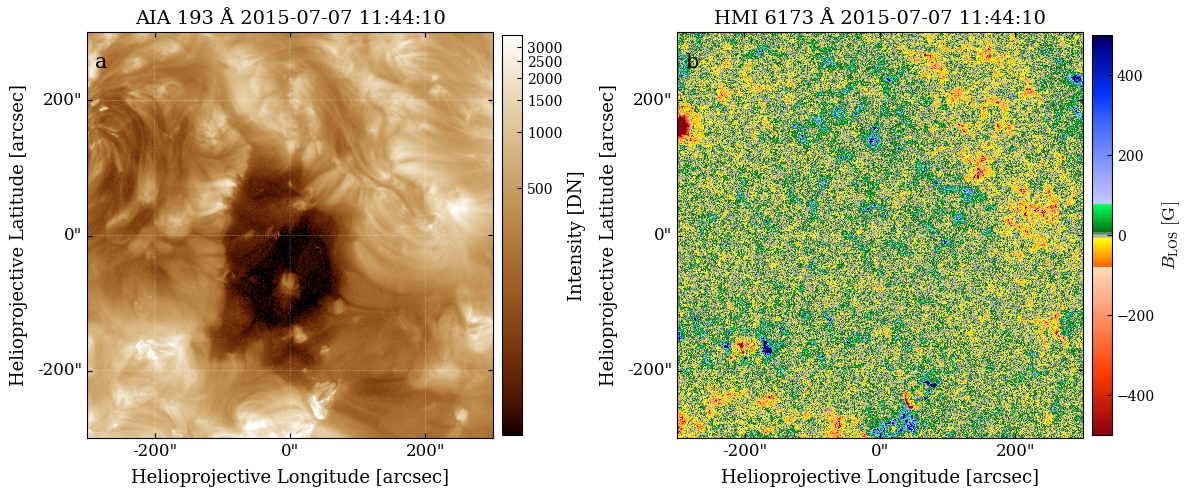

In [22]:
# -------------------------------------------------
# Global ApJ-safe style (ONE place)
# -------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# -------------------------------------------------
# Create submaps from defined region
# -------------------------------------------------
aia_sub  = aia_reprojected.submap(
    bottom_left=aia_bottom_left,
    top_right=aia_top_right
)
hmi_sub1 = hmi6173.submap(
    bottom_left=aia_bottom_left,
    top_right=aia_top_right
)

# -------------------------------------------------
# Create figure
# -------------------------------------------------
fig = plt.figure(figsize=(12, 6))

# ===================== AIA submap =====================
ax1 = fig.add_subplot(121, projection=aia_sub.wcs)
im1 = aia_sub.plot(
    axes=ax1,
    clip_interval=(1, 99.9) * u.percent
)

ax1.set_title("AIA 193 Å 2015-07-07 11:44:10", fontsize=14)

ax1.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)

# Enforce uniform label rendering (Astropy-safe)
ax1.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)

ax1.tick_params(labelsize=12)
ax1.invert_xaxis()
ax1.invert_yaxis()

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label("Intensity [DN]", fontsize=13)
cbar1.ax.tick_params(labelsize=10)

ax1.text(
    0.02, 0.95, "a",
    transform=ax1.transAxes,
    va="top", ha="left",
    fontsize=15
)

# ===================== HMI submap =====================
ax2 = fig.add_subplot(122, projection=hmi_sub1.wcs)
im2 = hmi_sub1.plot(
    axes=ax2,
    cmap="hmimag",
    norm=Normalize(-500, 500)
)

ax2.set_title("HMI 6173 Å 2015-07-07 11:44:10", fontsize=14)

ax2.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)

# Enforce uniform label rendering (Astropy-safe)
ax2.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)

ax2.tick_params(labelsize=12)
ax2.invert_xaxis()
ax2.invert_yaxis()

cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
cbar2.set_label(r"$B_{\mathrm{LOS}}\ \mathrm{[G]}$", fontsize=13)
cbar2.ax.tick_params(labelsize=10)

ax2.text(
    0.02, 0.95, "b",
    transform=ax2.transAxes,
    va="top", ha="left",
    fontsize=15
)

# -------------------------------------------------
# Final layout and show/save
# -------------------------------------------------
plt.tight_layout(pad=1.0)
# plt.savefig("/Users/khagendrakatwal/Desktop/AIA_HMI_submaps.pdf",
#             dpi=600, bbox_inches="tight")
plt.show()

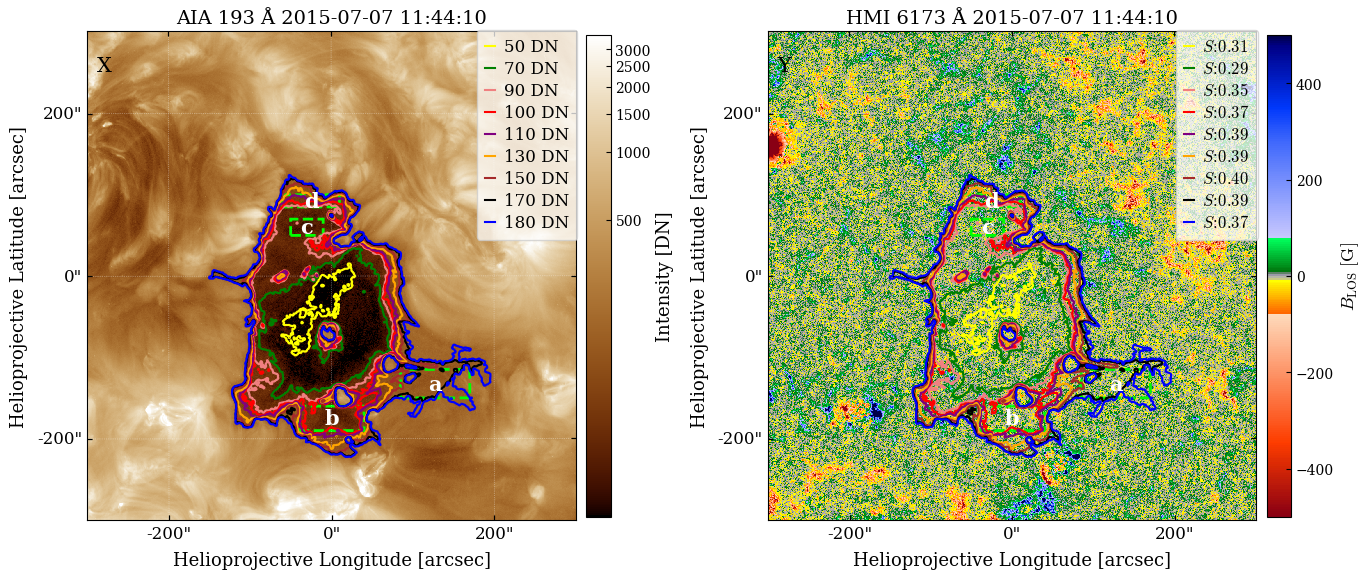

In [23]:
# -------------------------------------------------
# Global ApJ-uniform style (SAFE)
# -------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "xtick.direction": "in",
    "ytick.direction": "in",
})

def Skewness(region_map):
    mean = np.nanmean(region_map)
    median = np.nanmedian(region_map)
    std = np.nanstd(region_map)
    return 3 * (mean - median) / std if std != 0 else np.nan

thresholds = [50, 70, 90, 100, 110, 130, 150, 170, 180]
contour_colors = ['yellow','green','lightcoral','red','purple',
                  'orange','brown','black','blue']
skewness_values = []

# -------------------------------------------------
# Plot (MATCH submap / ROI style)
# -------------------------------------------------
fig = plt.figure(figsize=(14, 7))
gs = fig.add_gridspec(1, 2)

# =========================
# AIA panel
# =========================
ax1 = fig.add_subplot(gs[0, 0], projection=aia_sub.wcs)
im1 = aia_sub.plot(axes=ax1, clip_interval=(1, 99.9) * u.percent)
ax1.set_title("AIA 193 Å 2015-07-07 11:44:10", fontsize=14)

ax1.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)
ax1.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)

# WCS tick labels (helps PDF consistency)
ax1.coords[0].set_ticklabel(size=12)
ax1.coords[1].set_ticklabel(size=12)

for threshold, color in zip(thresholds, contour_colors):
    segmented = aia_sub.data < threshold
    smoothed = gaussian_filter(segmented.astype(float), sigma=2) > 0.5
    labeled = label(smoothed)
    regions = regionprops(labeled, intensity_image=aia_sub.data)
    if regions:
        largest = max(regions, key=lambda r: r.area)
        ax1.contour(labeled == largest.label, levels=[0.5],
                    colors=color, origin='lower')

dummy_lines = [
    Line2D([0], [0], color=color, label=f'{thr} DN')
    for thr, color in zip(thresholds, contour_colors)
]

ax1.legend(
    handles=dummy_lines,
    fontsize=12,
    loc='upper right',
    bbox_to_anchor=(1.02, 1.02),
    handlelength=0.60,
    borderpad=0.5,
    labelspacing=0.3,
    handletextpad=0.5,
    framealpha=0.75,
    fancybox=True
)

ax1.invert_xaxis()
ax1.invert_yaxis()

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label("Intensity [DN]", fontsize=13)
cbar1.ax.tick_params(labelsize=10)

ax1.text(0.02, 0.95, "X",
         transform=ax1.transAxes, va="top", ha="left",
         fontsize=15)

# =========================
# HMI panel
# =========================
ax2 = fig.add_subplot(gs[0, 1], projection=hmi_sub1.wcs)
im2 = hmi_sub1.plot(axes=ax2, cmap='hmimag', norm=Normalize(-500, 500))
ax2.set_title("HMI 6173 Å 2015-07-07 11:44:10", fontsize=14)

ax2.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)
ax2.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)

# WCS tick labels (helps PDF consistency)
ax2.coords[0].set_ticklabel(size=12)
ax2.coords[1].set_ticklabel(size=12)

for threshold, color in zip(thresholds, contour_colors):
    segmented = aia_sub.data < threshold
    smoothed = gaussian_filter(segmented.astype(float), sigma=2) > 0.5
    labeled = label(smoothed)
    regions = regionprops(labeled, intensity_image=hmi_sub1.data)
    if regions:
        largest = max(regions, key=lambda r: r.area)
        contour = labeled == largest.label
        ax2.contour(contour, levels=[0.5], colors=color, origin='lower')
        skewness_values.append(Skewness(hmi_sub1.data[contour]))
    else:
        skewness_values.append(np.nan)

dummy_lines2 = [
    Line2D([0], [0], color=color, label=rf'$S\!:\!{skew:.2f}$')
    for skew, color in zip(skewness_values, contour_colors)
]

ax2.legend(
    handles=dummy_lines2,
    fontsize=12,
    loc='upper right',
    bbox_to_anchor=(1.02, 1.02),
    handlelength=0.60,
    borderpad=0.5,
    labelspacing=0.3,
    handletextpad=0.5,
    framealpha=0.75,
    fancybox=True
)

ax2.invert_xaxis()
ax2.invert_yaxis()

cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
cbar2.set_label(r"$B_{\mathrm{LOS}}\ \mathrm{[G]}$", fontsize=13)
cbar2.ax.tick_params(labelsize=10)

ax2.text(0.02, 0.95, "Y",
         transform=ax2.transAxes, va="top", ha="left",
         fontsize=15)

# =========================
# Quadrangles + labels
# =========================
coords_list = [
    (SkyCoord(Tx=85*u.arcsec,  Ty=-150*u.arcsec, frame=hmi_sub1.coordinate_frame),
     SkyCoord(Tx=170*u.arcsec, Ty=-115*u.arcsec, frame=hmi_sub1.coordinate_frame)),
    (SkyCoord(Tx=-40*u.arcsec, Ty=-190*u.arcsec, frame=hmi_sub1.coordinate_frame),
     SkyCoord(Tx=40*u.arcsec,  Ty=-160*u.arcsec, frame=hmi_sub1.coordinate_frame)),
    (SkyCoord(Tx=-60*u.arcsec, Ty=85*u.arcsec,  frame=hmi_sub1.coordinate_frame),
     SkyCoord(Tx=10*u.arcsec,  Ty=100*u.arcsec, frame=hmi_sub1.coordinate_frame)),
    (SkyCoord(Tx=-50*u.arcsec, Ty=50*u.arcsec,  frame=hmi_sub1.coordinate_frame),
     SkyCoord(Tx=-10*u.arcsec, Ty=70*u.arcsec,  frame=hmi_sub1.coordinate_frame))
]

for lbl, (bl_hmi, tr_hmi) in zip(['a','b','d','c'], coords_list):

    bl_aia = bl_hmi.transform_to(aia_sub.coordinate_frame)
    tr_aia = tr_hmi.transform_to(aia_sub.coordinate_frame)

    aia_sub.draw_quadrangle(bottom_left=bl_aia, top_right=tr_aia,
                            axes=ax1, edgecolor='lime',
                            linestyle='--', linewidth=2)

    hmi_sub1.draw_quadrangle(bottom_left=bl_hmi, top_right=tr_hmi,
                             axes=ax2, edgecolor='lime',
                             linestyle='--', linewidth=2)

    center_hmi = SkyCoord(
        Tx=(bl_hmi.Tx + tr_hmi.Tx) / 2,
        Ty=(bl_hmi.Ty + tr_hmi.Ty) / 2,
        frame=hmi_sub1.coordinate_frame
    )
    center_aia = center_hmi.transform_to(aia_sub.coordinate_frame)

    cx1, cy1 = ax1.wcs.world_to_pixel(center_aia)
    ax1.text(cx1, cy1, lbl, fontsize=15, fontweight='bold',
             color='white', ha='center', va='center')

    cx2, cy2 = ax2.wcs.world_to_pixel(center_hmi)
    ax2.text(cx2, cy2, lbl, fontsize=15, fontweight='bold',
             color='white', ha='center', va='center')

# -------------------------------------------------
# IMPORTANT: DO NOT use tight_layout for WCSAxes + PDF
# Use manual spacing instead (fixes your PDF problem)
# -------------------------------------------------
plt.subplots_adjust(left=0.07, right=0.93, bottom=0.10, top=0.90, wspace=0.30)

plt.savefig(
    "/Users/khagendrakatwal/Desktop/aia_hmi_varying_boundary.pdf",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

# Boundary Selection 

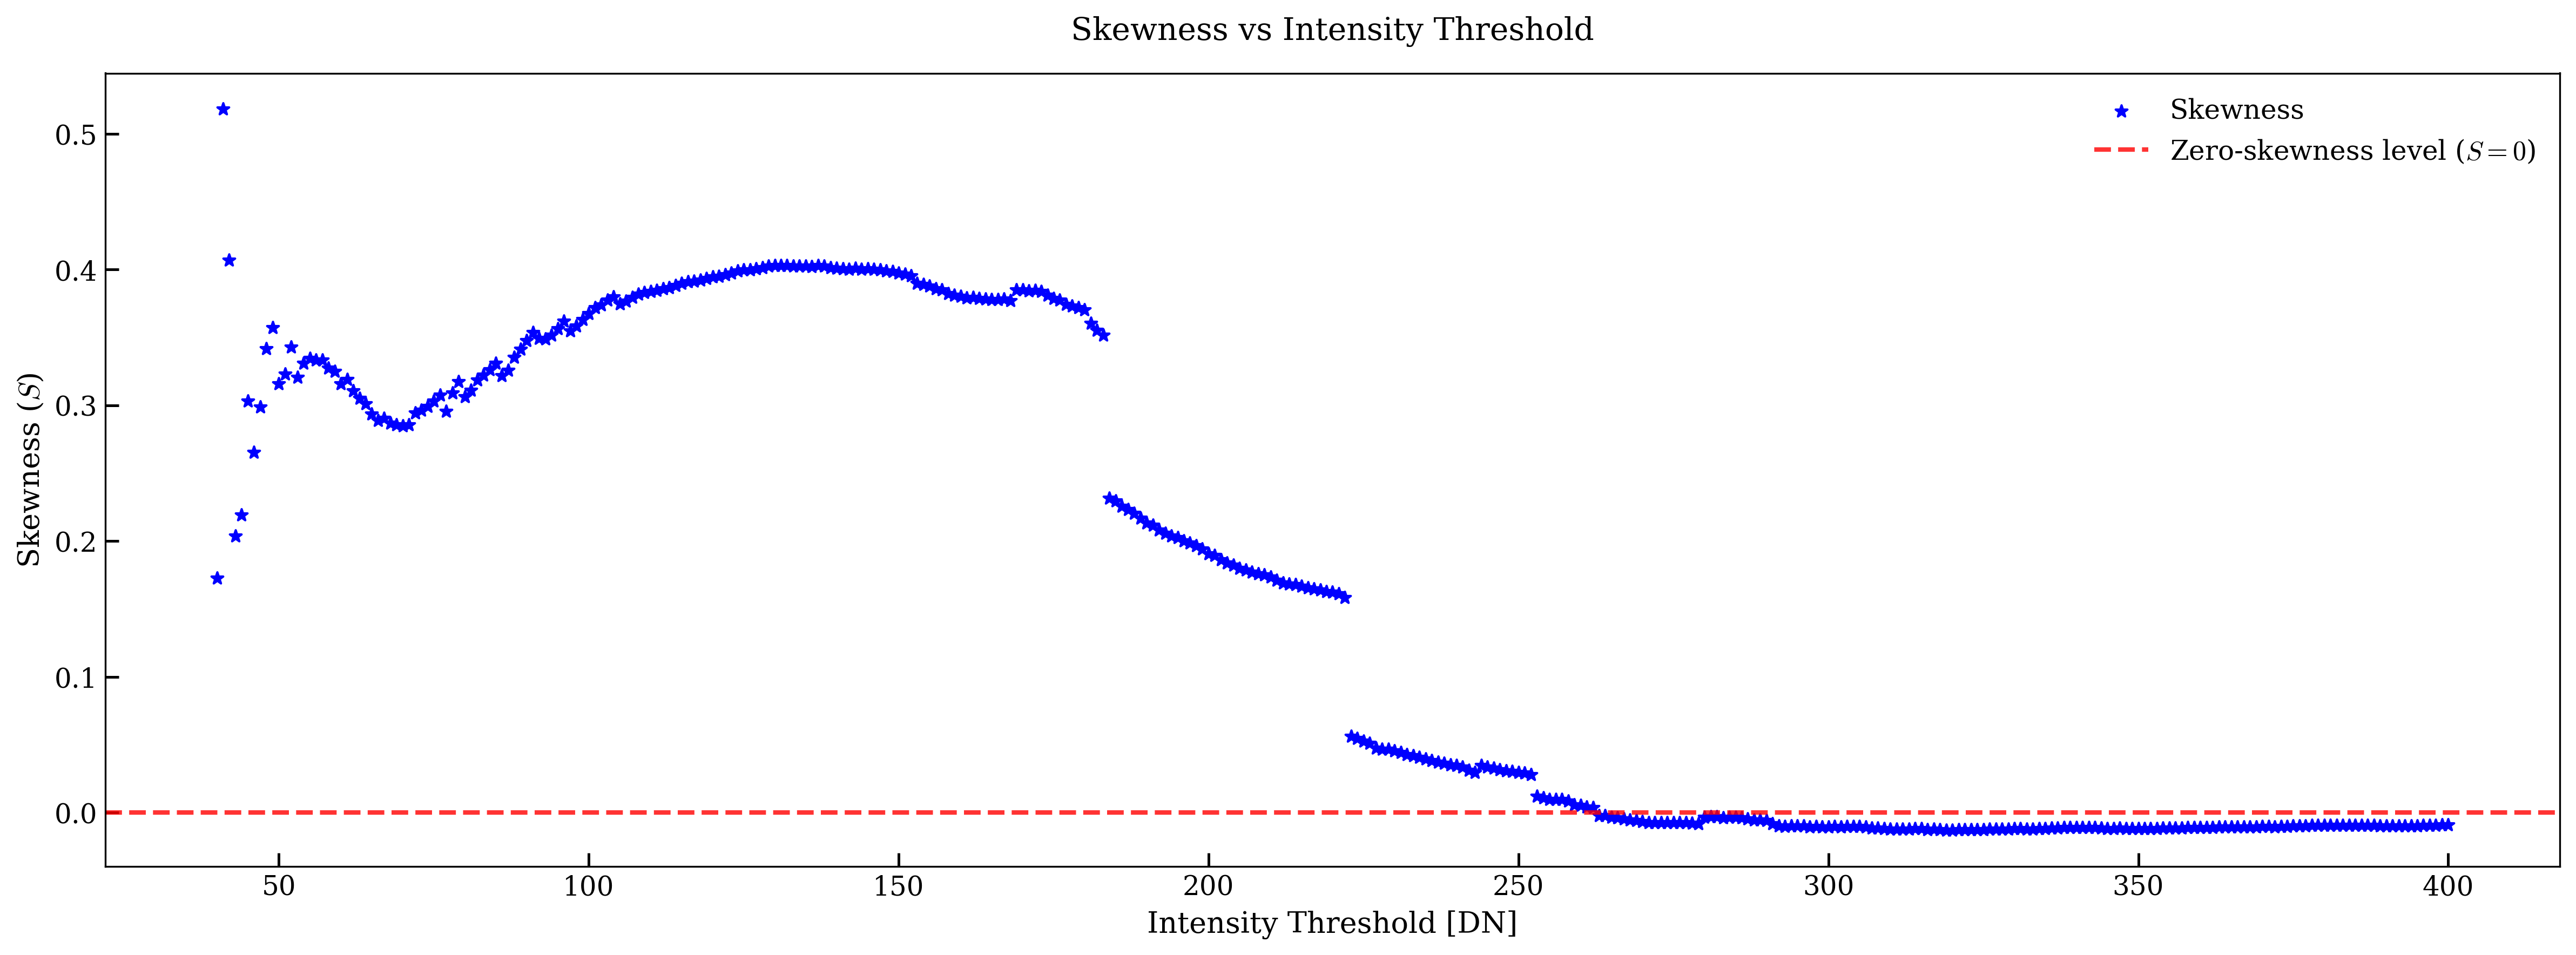

In [24]:
# ApJ-style global (same as your other figures)
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# ---- Skewness function (SAFE) ----
def Skewness(region_map):
    mean = np.nanmean(region_map)
    median = np.nanmedian(region_map)
    std = np.nanstd(region_map)
    return 3 * (mean - median) / std if std != 0 else np.nan

# Thresholds
thresholds = np.arange(40, 401, 1)
skewness_values = []

for threshold in thresholds:
    segmented = aia_sub.data < threshold
    labeled_img = label(segmented.astype(np.uint8))
    regions = regionprops(labeled_img)

    if not regions:
        skewness_values.append(np.nan)
        continue

    largest_region = max(regions, key=lambda r: r.area)
    mask = labeled_img == largest_region.label

    # use hmi_sub1 (your correct variable)
    skewness_values.append(Skewness(hmi_sub1.data[mask]))

# ---- Plot ----
plt.figure(figsize=(16, 6), dpi=300)

plt.scatter(
    thresholds,
    skewness_values,
    marker='*',
    s=30,
    color='blue',
    label='Skewness'
)

plt.axhline(
    0,
    color='red',
    linewidth=2.0,
    linestyle='--',
    alpha=0.8,
    label=r'Zero-skewness level ($S = 0$)'
)

#plt.xlim(40, 400)
#plt.ylim(0, 0.5)

plt.xlabel("Intensity Threshold [DN]", fontsize=13, fontfamily="serif")
plt.ylabel("Skewness ($S$)", fontsize=13, fontfamily="serif")
plt.title("Skewness vs Intensity Threshold", fontsize=14, fontfamily="serif", pad=15)

plt.tick_params(
    axis='both',
    labelsize=12,
    direction='in',
    length=6,
    width=1.2
)

plt.legend(
    frameon=False,
    fontsize=12,
    loc='upper right'
)

plt.tight_layout()

plt.savefig(
    "/Users/khagendrakatwal/Desktop/Variation_of_skewness.pdf",
    format="pdf",
    dpi=300,
    bbox_inches="tight"
)

plt.show()

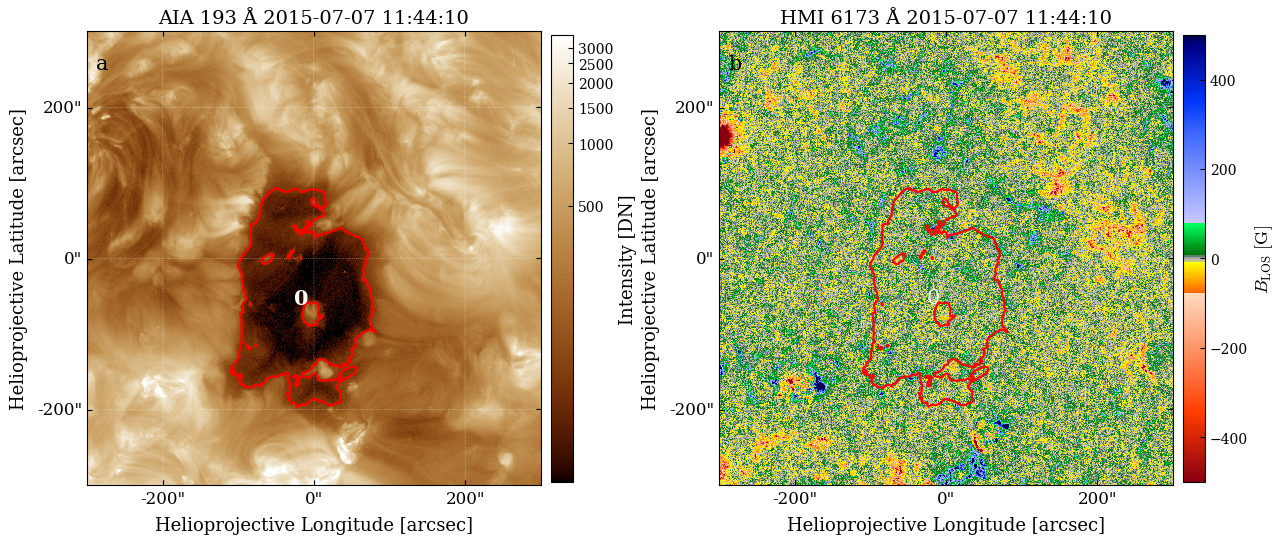

In [25]:
# -------------------------------------------------
# Global ApJ-uniform style (SAFE) — same as above
# -------------------------------------------------
plt.rcParams.update({
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "xtick.direction": "in",
    "ytick.direction": "in",
})

# -------------------------------------------------
# Segment AIA dark regions + smooth
# -------------------------------------------------
threshold = 100
segmented = aia_sub.data < threshold
smoothed_mask = gaussian_filter(segmented.astype(float), sigma=2) > 0.5

# Label regions (use AIA intensity image for region finding)
labeled = label(smoothed_mask)
regions = regionprops(labeled, intensity_image=aia_sub.data)
regions = sorted(regions, key=lambda r: r.area, reverse=True)

# Safety: handle empty detection
if len(regions) == 0:
    raise ValueError("No regions found. Try adjusting threshold/sigma.")

# Keep only largest region
largest_region = regions[0]
single_mask = (labeled == largest_region.label)

# Region centroid (pixel)
cy, cx = largest_region.centroid  # (row, col)

# -------------------------------------------------
# Plot (UNIFORM with the earlier figure: GridSpec + per-axis colorbars)
# -------------------------------------------------
fig = plt.figure(figsize=(13, 6))
gs = fig.add_gridspec(1, 2)

# ===================== AIA panel =====================
ax1 = fig.add_subplot(gs[0, 0], projection=aia_sub.wcs)
im1 = aia_sub.plot(axes=ax1, clip_interval=(1, 99.9) * u.percent)
ax1.contour(single_mask, levels=[0.5], colors="red", origin="lower")

ax1.set_title("AIA 193 Å 2015-07-07 11:44:10", fontsize=14)

ax1.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)
ax1.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)

# WCS tick labels (PDF consistency)
ax1.coords[0].set_ticklabel(size=12)
ax1.coords[1].set_ticklabel(size=12)

# label at centroid (bold like your other labels)
ax1.text(cx, cy, "0", color="white",
         ha="center", va="center", fontsize=15, fontweight="bold")

# panel label
ax1.text(0.02, 0.95, "a",
         transform=ax1.transAxes, va="top", ha="left",
         fontsize=15, color="black")

ax1.invert_xaxis()
ax1.invert_yaxis()

cbar1 = fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label("Intensity [DN]", fontsize=13)
cbar1.ax.tick_params(labelsize=10)

# ===================== HMI panel =====================
ax2 = fig.add_subplot(gs[0, 1], projection=hmi_sub1.wcs)
im2 = hmi_sub1.plot(axes=ax2, cmap="hmimag", norm=Normalize(-500, 500))
ax2.contour(single_mask, levels=[0.5], colors="red", origin="lower")

ax2.set_title("HMI 6173 Å 2015-07-07 11:44:10", fontsize=14)

ax2.coords[0].set_axislabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.coords[1].set_axislabel("Helioprojective Latitude [arcsec]", fontsize=13)
ax2.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax2.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)

# WCS tick labels (PDF consistency)
ax2.coords[0].set_ticklabel(size=12)
ax2.coords[1].set_ticklabel(size=12)

# same centroid label
ax2.text(cx, cy, "0", color="white",
         ha="center", va="center", fontsize=15)

# panel label
ax2.text(0.02, 0.95, "b",
         transform=ax2.transAxes, va="top", ha="left",
         fontsize=15, color="black")

ax2.invert_xaxis()
ax2.invert_yaxis()

cbar2 = fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.02)
cbar2.set_label(r"$B_{\mathrm{LOS}}\ \mathrm{[G]}$", fontsize=13)
cbar2.ax.tick_params(labelsize=10)

# -------------------------------------------------
# IMPORTANT: no tight_layout for WCSAxes + PDF
# -------------------------------------------------
plt.subplots_adjust(left=0.07, right=0.93, bottom=0.10, top=0.90, wspace=0.30)

plt.savefig(
    "/Users/khagendrakatwal/Desktop/Final_coronal_hole.pdf",
    dpi=300,
    bbox_inches="tight"
)
plt.show()


In [14]:
# Create mask from largest region
bbox = regions[0].bbox
mask = np.ones_like(hmi_sub1.data, dtype=bool)
mask[bbox[0]: bbox[2], bbox[1]: bbox[3]] = ~regions[0].image

# Create masked SunPy map
hmi_masked = sunpy.map.Map((hmi_sub1.data, hmi_sub1.meta), mask=mask)

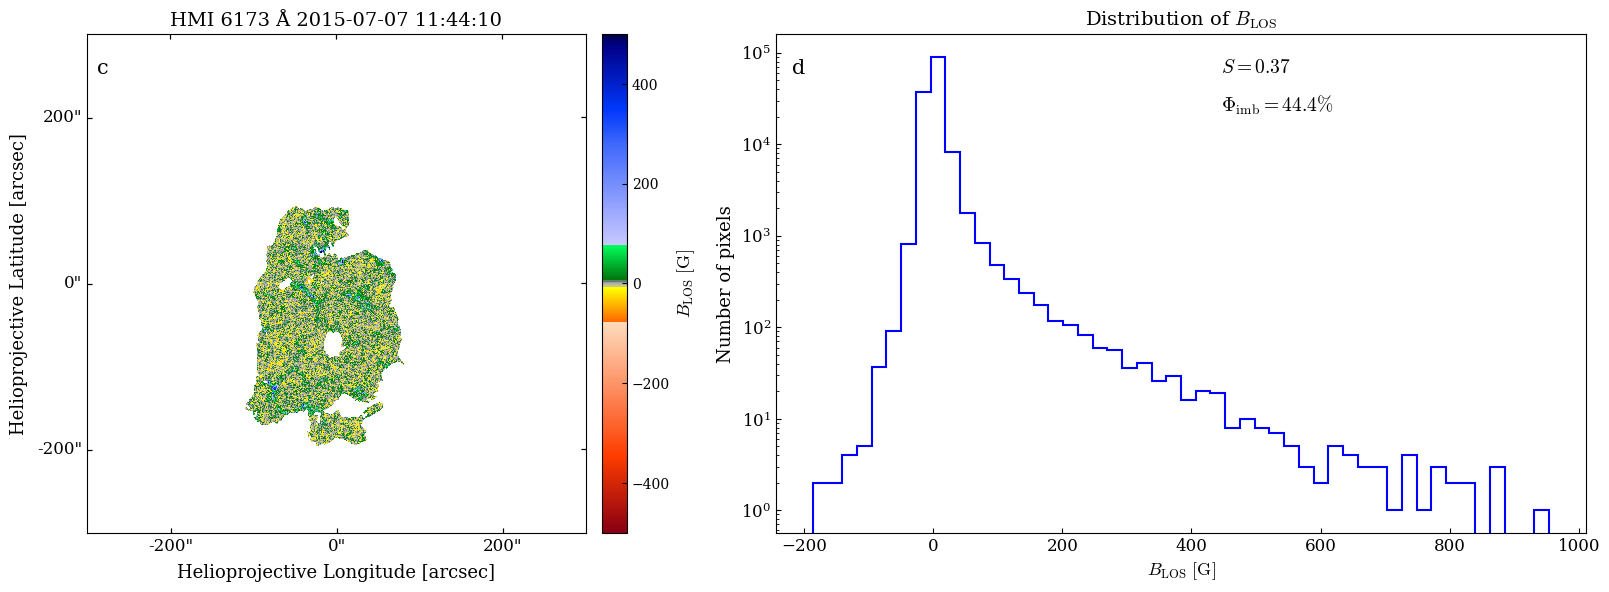

In [15]:
# Extract unmasked data
unmasked_data = hmi_masked.data[~hmi_masked.mask]

# Create figure with two subplots
fig = plt.figure(figsize=(18, 6))

# ===================== Masked HMI Map =====================
ax1 = fig.add_subplot(121, projection=hmi_masked)
im = hmi_masked.plot(axes=ax1, cmap="hmimag", norm=Normalize(-500, 500))

ax1.set_title("HMI 6173 Å 2015-07-07 11:44:10", fontsize=14)
ax1.set_xlabel("Helioprojective Longitude [arcsec]", fontsize=13)
ax1.set_ylabel("Helioprojective Latitude [arcsec]", fontsize=13)
ax1.tick_params(labelsize=12, direction="in")

ax1.invert_xaxis()
ax1.invert_yaxis()

# ✅ Colorbar EXACTLY like the AIA+HMI figure (fraction + pad only)
cbar1 = fig.colorbar(im, ax=ax1, fraction=0.046, pad=0.02)
cbar1.set_label(r"$B_{\mathrm{LOS}}\ \mathrm{[G]}$", fontsize=13)
cbar1.ax.tick_params(labelsize=10)

# Panel label
ax1.text(0.02, 0.95, "c",
         transform=ax1.transAxes,
         va="top", ha="left",
         fontsize=15)

# ===================== Histogram =====================
ax2 = fig.add_subplot(122)
ax2.hist(unmasked_data, bins=50, histtype="step", color="blue", linewidth=1.5)

ax2.set_yscale("log")
ax2.set_xlabel(r"$B_{\mathrm{LOS}}\ \mathrm{[G]}$", fontsize=13)
ax2.set_ylabel("Number of pixels", fontsize=13)
ax2.set_title(r"Distribution of $B_{\mathrm{LOS}}$", fontsize=14)
ax2.tick_params(labelsize=12, direction="in")

# Annotations
ax2.text(0.55, 0.95, r"$S = 0.37$",
         transform=ax2.transAxes,
         va="top", ha="left",
         fontsize=14)

ax2.text(0.55, 0.88, r"$\Phi_{\mathrm{imb}} = 44.4\%$",
         transform=ax2.transAxes,
         va="top", ha="left",
         fontsize=14)

# Panel label
ax2.text(0.02, 0.95, "d",
         transform=ax2.transAxes,
         va="top", ha="left",
         fontsize=15)

plt.savefig(
    "/Users/khagendrakatwal/Desktop/Coronal_map_histogram1.pdf",
    dpi=300,
    bbox_inches="tight"
)

# Layout
plt.tight_layout(pad=1.0)
plt.show()

## Acknowledgments

This notebook uses [SunPy](https://sunpy.org), an open-source Python package for solar physics. We acknowledge the SunPy Project and its community:

- SunPy Community et al. (2015)
- Mumford et al. (2020)
- The SunPy Community et al. (2023)
